In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import numpy as np
import pandas as pd
from typing import List, Dict

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

from alibi.datasets import fetch_adult
from alibi.explainers.backends.cfrl_tabular import apply_category_mapping

from alibi.prototypes import ProtoSelect
from alibi.prototypes.protoselect import cv_protoselect_euclidean, visualize_prototypes
from alibi.utils.kernel import EuclideanDistance

%load_ext autoreload
%autoreload 2

/home/robert/anaconda3/envs/alibi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Tabular dataset

### Utils

In [4]:
def display_table(X: np.ndarray, 
                  Y: np.ndarray, 
                  feature_names: List[str],
                  category_map: Dict[int, List[str]],
                  target_names: List[str]) -> pd.DataFrame:
    """
    Displays the table in a human readable format.
    
    Parameters
    ----------
    X
        Array of data instances to be displayed.
    Y
        Array of data labels.
    feature_names
        List of feature names.
    category_map
        Category mapping dictionary having as keys the categorical index and as values the categorical values#
        each feature takes.
    target_names
        List of label names.
    
    Return
    ------
    DataFrame containing the concatenation of X and Y in a human readable format.
    """
    # Concat labels to the original instances.
    orig = np.concatenate([X, Y.reshape(-1, 1)], axis=1)

    # Define new feature names and category map by including the label.
    feature_names = feature_names + ["Label"]
    category_map.update({feature_names.index("Label"): [target_names[i] for i in np.unique(Y)]})

    # Replace label encodings with strings.
    df = pd.DataFrame(
        apply_category_mapping(orig, category_map),
        columns=feature_names
    )
    
    dfs = []
    for l in np.unique(Y):
        dfs.append(df[df['Label'] == target_names[l]])
        
    return pd.concat(dfs)

### Load Adult Census dataset

In [5]:
# fetch adult datasets
adult = fetch_adult()

# split dataset into train-test-validation
X, Y = adult.data, adult.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=1000, test_size=2000, random_state=13)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=13)

# identify numerical and categorical columns
categorical_ids = list(adult.category_map.keys())
numerical_ids = [i for i in range(len(adult.feature_names)) if i not in adult.category_map]

### Preprocessing function

In [6]:
# define data preprocessor
num_transf = StandardScaler()
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in adult.category_map.values()],
    handle_unknown='ignore'
)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_ids),
        ('num', num_transf, numerical_ids)
    ],
    sparse_threshold=0
)

# fit data perprocessor
preprocessor = preprocessor.fit(adult.data)

### Prototypes selection

In [7]:
num_prototypes = 20
grid_size = 25
quantiles = (0., .4)

# search for the best epslion-radius value
cv = cv_protoselect_euclidean(refset=(X_train, Y_train),
                              protoset=(X_train,),
                              valset=(X_val, Y_val),
                              num_prototypes=num_prototypes,
                              quantiles=quantiles,
                              grid_size=grid_size,
                              preprocess_fn=preprocessor.transform)

In [8]:
explainer = ProtoSelect(kernel_distance=EuclideanDistance(), 
                        eps=cv['best_eps'], 
                        preprocess_fn=preprocessor.transform)

explainer = explainer.fit(X=X_train, X_labels=Y_train, Y=X_train)
explanation = explainer.explain(num_prototypes=num_prototypes)
print(f"Found {len(explanation.data['prototypes'])} prototypes.")

Found 20 prototypes.


### Display prototypes

In [9]:
protos = explanation.data['prototypes']
protos_labels = explanation.data['prototypes_labels']

# display the prototypes in a human readable format
display_table(X=protos, Y=protos_labels, feature_names=adult.feature_names, category_map=adult.category_map, target_names=adult.target_names)

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Label
0,30,Private,High School grad,Never-Married,Blue-Collar,Not-in-family,White,Male,0,0,40,United-States,<=50K
1,31,Private,High School grad,Never-Married,Service,Own-child,White,Female,0,0,30,United-States,<=50K
2,44,Private,High School grad,Separated,Admin,Unmarried,White,Female,0,0,40,United-States,<=50K
3,56,Private,Dropout,Separated,Blue-Collar,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,23,Private,High School grad,Never-Married,Admin,Own-child,White,Male,1055,0,20,United-States,<=50K
5,63,Self-emp-not-inc,Dropout,Married,White-Collar,Husband,White,Male,0,0,15,United-States,<=50K
6,35,Private,Dropout,Never-Married,Service,Unmarried,Black,Female,0,0,38,United-States,<=50K
7,28,Federal-gov,Bachelors,Never-Married,Professional,Not-in-family,White,Female,0,0,40,United-States,<=50K
8,40,State-gov,Dropout,Separated,Blue-Collar,Not-in-family,Black,Male,0,0,40,United-States,<=50K
9,21,?,High School grad,Never-Married,?,Own-child,White,Female,0,0,35,United-States,<=50K


By inspecting the prototypes, we can observe that features like `Education` and `Marital Status` can reveal some patterns. People with lower education level (e.g., `High School grad`, `Dropout` etc.) and who don’t have a partner (e.g., `Never-Married`, `Separated`, `Widowed` etc.) tend to be classified as $\leq 50K$. On the other hand, we have people that have a higher education level (e.g., `Bachelors`, `Masters`, `Doctorate`)  and whom have a partner (e.g., `Married`) that are classified as $>50K$.

### Train 1-KNN

In [10]:
# train 1-knn classifier using the selected prototypes
knn_proto = KNeighborsClassifier(n_neighbors=1)
knn_proto = knn_proto.fit(X=preprocessor.transform(protos), y=protos_labels)

In [11]:
np.random.seed(0)
scores = []

for i in range(10):
    rand_idx = np.random.choice(len(X_train), size=len(protos), replace=False)
    rands, rands_labels = X_train[rand_idx], Y_train[rand_idx]
    
    knn_rand = KNeighborsClassifier(n_neighbors=1)
    knn_rand = knn_rand.fit(X=preprocessor.transform(rands), y=rands_labels)
    scores.append(knn_rand.score(preprocessor.transform(X_test), Y_test))

In [12]:
# compare the scores obtained by ProtoSelect vs random choice
print('ProtoSelect 1-KNN accuracy: %.3f' % (knn_proto.score(preprocessor.transform(X_test), Y_test)))
print('Random 1-KNN mean accuracy: %.3f' % (np.mean(scores)))

ProtoSelect 1-KNN accuracy: 0.816
Random 1-KNN mean accuracy: 0.723


We can observe that `ProtoSelect` chooses more representative instances than a naive random selection. The gap between the two should narrow as more prototypes are requested but that can complicate the analysis.

## Image dataset

### Load dataset

In [13]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.
Y_train, Y_test = Y_train.flatten(), Y_test.flatten()


# split the test into test-validation
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, train_size=1000, test_size=1000, random_state=13)

# subsample the datasets
np.random.seed(13)
train_idx = np.random.choice(len(X_train), size=1000, replace=False)
X_train, Y_train = X_train[train_idx], Y_train[train_idx]

### Preprocessing function

For CIFAR10 we will use a hidden layer output from a pretrained network as our feature representation of the input images. The network was traiend on the CIFAR10 dataset.

In [14]:
# download weights
!wget https://storage.googleapis.com/seldon-models/alibi/model_cifar10/checkpoint -P model_cifar10
!wget https://storage.googleapis.com/seldon-models/alibi/model_cifar10/cifar10.ckpt.data-00000-of-00001 -P model_cifar10
!wget https://storage.googleapis.com/seldon-models/alibi/model_cifar10/cifar10.ckpt.index -P model_cifar10

--2022-04-06 13:41:41--  https://storage.googleapis.com/seldon-models/alibi/model_cifar10/checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.200.16, 172.217.16.240, 216.58.212.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.200.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81 [application/octet-stream]
Saving to: ‘model_cifar10/checkpoint’

checkpoint          100%[===================>]      81  --.-KB/s    in 0s      

2022-04-06 13:41:41 (3,30 MB/s) - ‘model_cifar10/checkpoint’ saved [81/81]

--2022-04-06 13:41:41--  https://storage.googleapis.com/seldon-models/alibi/model_cifar10/cifar10.ckpt.data-00000-of-00001
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.200.16, 172.217.16.240, 216.58.212.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.200.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218891 (2,1M) [applic

In [15]:
# define the network to be used.
model = keras.Sequential([
        layers.InputLayer(input_shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(128, kernel_initializer='he_uniform', name='feature_layer'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10)
])

# load the weights
model.load_weights('model_cifar10/cifar10.ckpt');

In [16]:
# define preprocessing function
partial_model = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name='feature_layer').output
)

def preprocess_fn(x: np.ndarray):
    return partial_model(x, training=False).numpy()

### Prototypes selection

In [17]:
num_prototypes = 50
grid_size = 50
quantiles = (0.0, 0.2)

# get best eps by cv
cv = cv_protoselect_euclidean(refset=(X_train, Y_train),
                              protoset=(X_train,),
                              valset=(X_val, Y_val),
                              num_prototypes=num_prototypes,
                              quantiles=quantiles,
                              grid_size=grid_size,
                              preprocess_fn=preprocess_fn,
                              batch_size=100)

In [18]:
explainer = ProtoSelect(kernel_distance=EuclideanDistance(), 
                        eps=cv['best_eps'], 
                        preprocess_fn=preprocess_fn)

explainer = explainer.fit(X=X_train, X_labels=Y_train, Y=X_train)
explanation = explainer.explain(num_prototypes=num_prototypes)
print(f"Found {len(explanation.data['prototypes'])} prototypes.")

Found 22 prototypes.


### Display prototypes

In [19]:
!pip install umap-learn

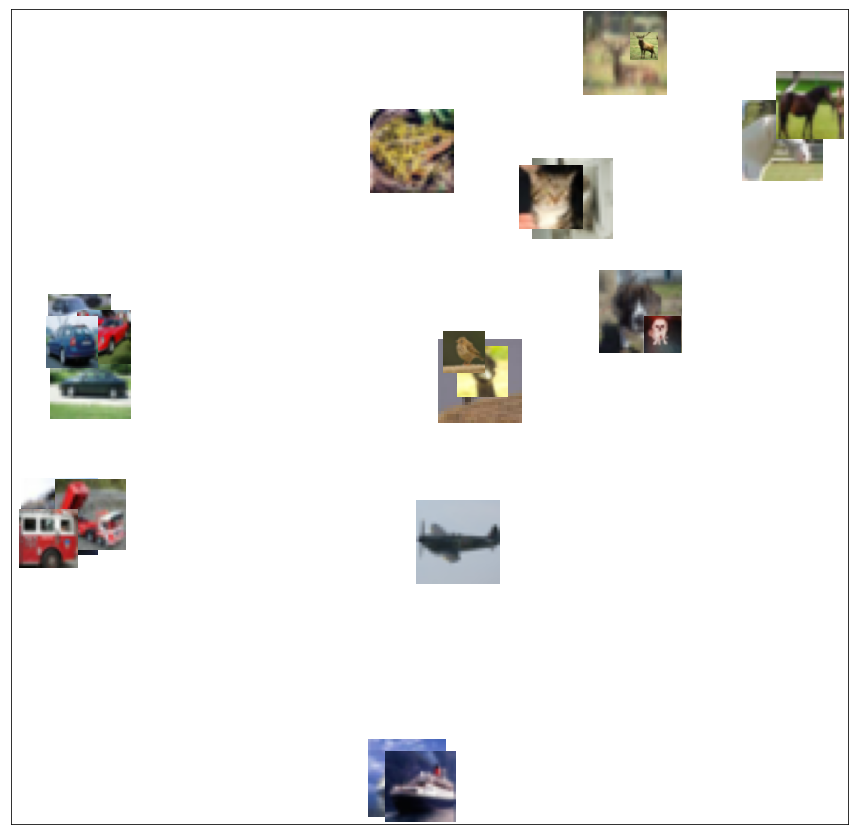

In [20]:
import umap

# define 2D reducer
reducer = umap.UMAP(random_state=26)
reducer = reducer.fit(preprocess_fn(X_train))

# display prototypes in 2D
visualize_prototypes(explanation=explanation,
                     refset=(X_train, Y_train),
                     reducer=reducer.transform,
                     preprocess_fn=preprocess_fn,
                     figsize=(15, 15))

### Train 1-KNN

In [21]:
# train 1-knn classifier using the selected prototypes
protos = explanation.data['prototypes']
protos_labels = explanation.data['prototypes_labels']
knn_proto = KNeighborsClassifier(n_neighbors=1)
knn_proto = knn_proto.fit(X=preprocess_fn(protos), y=protos_labels)

In [22]:
np.random.seed(0)
scores = []

for i in range(10):
    rand_idx = np.random.choice(len(X_train), size=len(protos), replace=False)
    rands, rands_labels = X_train[rand_idx], Y_train[rand_idx]
    
    knn_rand = KNeighborsClassifier(n_neighbors=1)
    knn_rand = knn_rand.fit(X=preprocess_fn(rands), y=rands_labels)
    scores.append(knn_rand.score(preprocess_fn(X_test), Y_test))

In [23]:
print('ProtoSelect 1-KNN accuracy: %.3f' % (knn_proto.score(preprocess_fn(X_test), Y_test)))
print('Random 1-KNN mean accuracy: %.3f' % (np.mean(scores)))

ProtoSelect 1-KNN accuracy: 0.871
Random 1-KNN mean accuracy: 0.721
